<a href="https://colab.research.google.com/github/sungjae2004/AIIA_AFAC_1/blob/main/AIIA_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import torchvision
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from tqdm import tqdm
import torch.nn.functional as F
from collections import Counter
from PIL import Image, ImageEnhance
import torchvision.transforms as transforms




In [2]:
# Google Drive 마운트
drive.mount('/content/drive')

# GPU 사용 여부 확인
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using Device:", DEVICE)


Mounted at /content/drive
Using Device: cuda


In [3]:
!pip install gdown==4.6.0

  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.0
    Uninstalling gdown-5.2.0:
      Successfully uninstalled gdown-5.2.0


In [4]:
!gdown https://drive.geogle.com/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E

Downloading...
From: https://drive.geogle.com/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E
To: /content/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E
100% 2.02k/2.02k [00:00<00:00, 13.8MB/s]


In [5]:
!unzip /content/drive/MyDrive/Original_Food_10.zip -d "/content/drive/MyDrive/Unzipped_Food4"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/drive/MyDrive/Unzipped_Food4/oysters/oysters_101.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food4/oysters/oysters_102.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food4/oysters/oysters_103.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food4/oysters/oysters_104.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food4/oysters/oysters_105.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food4/oysters/oysters_106.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food4/oysters/oysters_107.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food4/oysters/oysters_108.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food4/oysters/oysters_109.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food4/oysters/oysters_11.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food4/oysters/oysters_110.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food4/oysters/oysters_111.jpg  
  inflating: /content/drive/MyDrive/Unzip

In [6]:
# 데이터 경로 설정
path = "/content/drive/MyDrive/Unzipped_Food4"

In [7]:
# 학습 설정값
validation_split = 0.2
batch_size = 32
LR = 1e-3
model_type = "ResNet101_Custom_lr0.001_bs_32_"
criterion = nn.CrossEntropyLoss()
shuffle_dataset = True
random_seed = 42

In [8]:
# 커스텀 Sharpness 조정 클래스
class AdjustSharpnessCustom:
    def __init__(self, sharpness_factor):
        self.sharpness_factor = sharpness_factor

    def __call__(self, img):
        enhancer = ImageEnhance.Sharpness(img)
        return enhancer.enhance(self.sharpness_factor)

In [9]:
# 데이터 전처리 및 증강
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # 수평 플립
        transforms.CenterCrop(256),  # 중앙 크롭
        transforms.ToTensor(),  # 텐서로 변환
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # 정규화
    ]),
    "test": transforms.Compose([
        transforms.Resize((256, 256)),  # 더 큰 크기로 리사이즈
        transforms.ToTensor(),  # 텐서로 변환
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # 정규화
    ])
}


In [10]:
# 데이터셋 불러오기
image_datasets = datasets.ImageFolder(path, transform=data_transforms["train"])
class_names = image_datasets.classes  # 클래스 목록 가져오기

In [11]:



# 데이터셋 분할
dataset_size = len(image_datasets)
test_split = 0.1
val_split = 0.2
print(dataset_size)

test_size = int(np.floor(test_split * dataset_size))
val_size = int(np.floor(val_split * dataset_size))
train_size = dataset_size - val_size - test_size

train_dataset, val_dataset, test_dataset = random_split(image_datasets, [train_size, val_size, test_size])
print(test_size, val_size, train_size)

10000
1000 2000 7000


In [12]:
# 검증 & 테스트 데이터에는 augmentation을 적용하지 않도록 transform 수정
val_dataset.dataset.transform = data_transforms["test"]
test_dataset.dataset.transform = data_transforms["test"]

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 데이터 로딩 확인
inputs, classes = next(iter(train_loader))
print("Train Batch Labels:", classes)

Train Batch Labels: tensor([3, 2, 0, 1, 8, 8, 5, 9, 4, 5, 3, 1, 6, 4, 7, 6, 1, 9, 6, 2, 6, 0, 3, 7,
        9, 8, 2, 2, 8, 6, 1, 4])


샘플 라벨 5개 출력:
tensor([6, 3, 0, 6, 0])


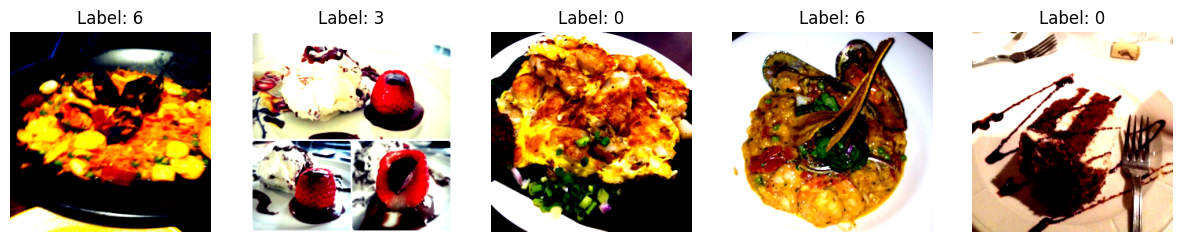

샘플 라벨 5개 출력:
tensor([4, 6, 8, 3, 1])


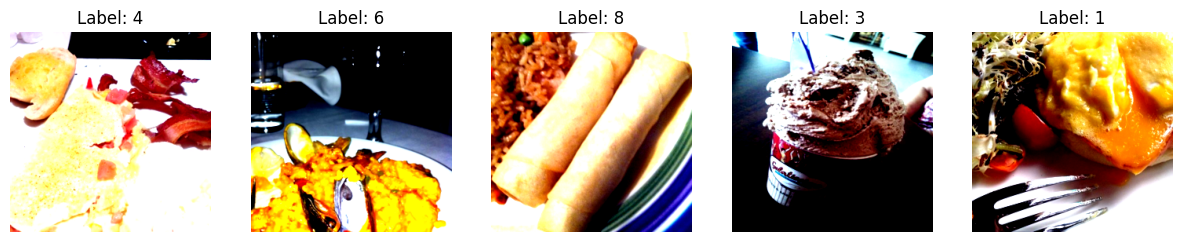

In [13]:
# 데이터 로더에서 샘플 배치 확인
def check_labels(dataloader, num_samples=5):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    print(f"샘플 라벨 {num_samples}개 출력:")
    print(labels[:num_samples])

    # 시각화 (이미지 & 라벨 확인)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {labels[i].item()}")
        axes[i].axis("off")

    plt.show()

# 학습 데이터 로더에서 확인
check_labels(train_loader)

# 검증 데이터 로더에서도 확인 가능
check_labels(validation_loader)


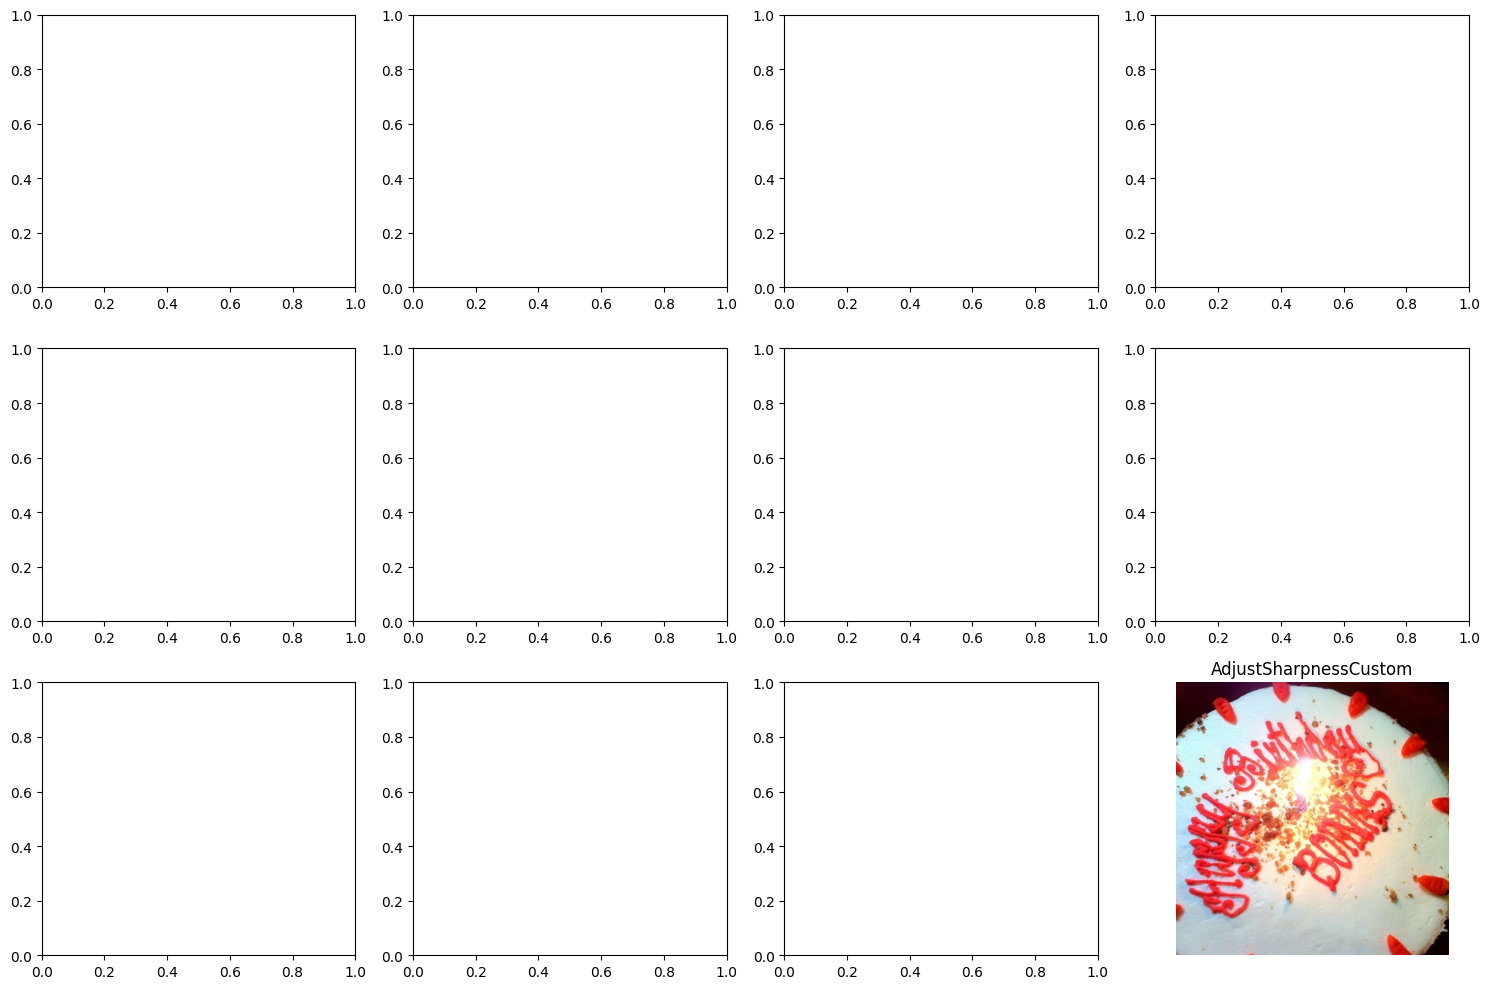

In [14]:

# 샘플 이미지 불러오기
sample_img_path, _ = image_datasets.samples[0]  # 데이터셋에서 첫 번째 이미지
sample_img = Image.open(sample_img_path).convert("RGB")  # RGB 변환

# 시드 고정 (랜덤 변환 결과 일관성 유지)
torch.manual_seed(42)

# Augmentation 과정별 변환 리스트 (랜덤 값 고정)
transform_steps = [
    ("Original", transforms.ToTensor()),
    ("RandomResizedCrop", transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
        transforms.ToTensor()
    ])),
    ("RandomHorizontalFlip", transforms.Compose([
        transforms.RandomHorizontalFlip(1.0),  # 항상 실행
        transforms.ToTensor()
    ])),
    ("RandomRotation", transforms.Compose([
        transforms.RandomRotation(degrees=20),
        transforms.ToTensor()
    ])),
    ("RandomAffine", transforms.Compose([
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1)),
        transforms.ToTensor()
    ])),
    ("ColorJitter", transforms.Compose([
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3, hue=0.08),
        transforms.ToTensor()
    ])),
    ("RandomPerspective", transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=1.0),  # 항상 실행
        transforms.ToTensor()
    ])),
    ("GaussianBlur", transforms.Compose([
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=1.0),
        transforms.ToTensor()
    ])),
    ("RandomErasing", transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomErasing(p=1.0, scale=(0.02, 0.1), ratio=(0.3, 3.3))
    ])),
    ("CenterCrop", transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])),
    ("AdjustSharpnessCustom", transforms.Compose([
        AdjustSharpnessCustom(1.5),
        transforms.ToTensor()
    ]))
]

# 이미지 출력 함수
def show_image(tensor, title):
    img = tensor.numpy().transpose((1, 2, 0))  # (C, H, W) → (H, W, C)
    img = (img - img.min()) / (img.max() - img.min())  # 0~1 범위로 정규화
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

# 변환된 이미지 출력
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

# 각 변환을 순차적으로 적용
for ax, (name, transform) in zip(axes.flat, transform_steps):
    transformed_img = transform(sample_img)  # 변환 적용
    show_image(transformed_img, name)

plt.tight_layout()
plt.show()


In [15]:
def conv3x3(in_planes, out_planes, stride, padding=1, bias=False):
    return nn.Conv2d(in_planes, out_planes,
        kernel_size=3,
        stride=stride,
        padding=padding,
        bias=bias
    )

def conv1x1(in_planes, out_planes, stride, padding=0, bias=False):
    return nn.Conv2d(in_planes, out_planes,
        kernel_size=1,
        stride=stride,
        padding=padding,
        bias=bias
    )

class BottleNeck(nn.Module):
    mul = 4
    def __init__(self, in_planes, out_planes, stride=1, dropout_rate=0.3):
        super(BottleNeck, self).__init__()

        self.conv1 = conv1x1(in_planes, out_planes, stride)
        self.conv2 = conv3x3(out_planes, out_planes, 1, 1)
        self.conv3 = conv1x1(out_planes, out_planes * self.mul, 1)

        self.bn1 = nn.BatchNorm2d(out_planes)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.bn3 = nn.BatchNorm2d(out_planes * self.mul)

        self.dropout = nn.Dropout(p=dropout_rate)  # ⬅️ Dropout 추가

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes * self.mul:
            self.shortcut = nn.Sequential(
                conv1x1(in_planes, out_planes * self.mul, stride),
                nn.BatchNorm2d(out_planes * self.mul)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.dropout(out)  # ⬅️ Dropout 적용

        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.dropout(out)  # ⬅️ Dropout 적용

        out = self.conv3(out)
        out = self.bn3(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, dropout_rate=0.5):
        super(ResNet, self).__init__()

        self.in_planes = 64
        self.conv = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding=3)
        self.bn = nn.BatchNorm2d(self.in_planes)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        _layers = []
        outputs, strides = [64, 128, 256, 512], [1, 2, 2, 2]
        for i in range(4):
            _layers.append(self._make_layer(block, outputs[i], num_blocks[i], stride=strides[i]))
        self.layers = nn.Sequential(*_layers)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_rate)  # ⬅️ Dropout 추가
        self.linear = nn.Linear(512 * block.mul, num_classes)

    def _make_layer(self, block, out_planes, num_block, stride):
        layers = [block(self.in_planes, out_planes, stride)]
        self.in_planes = block.mul * out_planes
        for i in range(num_block - 1):
            layers.append(block(self.in_planes, out_planes, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = F.relu(out)
        out = self.maxpool(out)
        out = self.layers(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)  # ⬅️ Dropout 적용
        out = self.linear(out)
        return out


In [16]:
# CNN Feature Map 시각화 추가
def visualize_feature_maps(model, image, device):
    model.eval()
    image = image.unsqueeze(0).to(device)  # 배치 차원 추가
    with torch.no_grad():
        for name, layer in model.named_children():
            if isinstance(layer, torch.nn.Conv2d):
                feature_map = layer(image)
                feature_map = feature_map.cpu().squeeze(0)
                num_features = feature_map.shape[0]
                fig, axes = plt.subplots(1, min(num_features, 6), figsize=(15, 5))
                for i in range(min(num_features, 6)):
                    axes[i].imshow(feature_map[i], cmap='viridis')
                    axes[i].axis('off')
                plt.show()
                break

# 입력 이미지 상위 5개 예측 결과 출력 함수 추가
def predict_top5(model, image, class_names, device):
    model.eval()
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        probs = F.softmax(outputs, dim=1)
        top5_probs, top5_indices = torch.topk(probs, 5)

    top5_probs = top5_probs.cpu().numpy().flatten()
    top5_indices = top5_indices.cpu().numpy().flatten()

    print("Top 5 Predictions:")
    for i in range(5):
        print(f"{class_names[top5_indices[i]]}: {top5_probs[i] * 100:.2f}%")

In [17]:
def ResNet18():
    return ResNet(BottleNeck, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BottleNeck, [3, 4, 6, 3])

def ResNet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def ResNet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [18]:
model = ResNet101()
model = model.to(DEVICE)

In [19]:
model

ResNet(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): BottleNeck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (shortcut): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), s

In [20]:
# 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

In [21]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [22]:
from collections import Counter

labels = [label for _, label in image_datasets.samples]
class_counts = Counter(labels)
print(class_counts)  # 클래스별 데이터 개수 출력


Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000})


In [23]:
# 모델 저장 & 로드 함수
def save_model(model, path="best_model.pth"):
    torch.save(model.state_dict(), path)
    print(f" 모델 저장 완료: {path}")

def load_model(model, path="best_model.pth", device="cpu"):
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    print(f"🔹 Model loaded from {path} to {device}")
    return model

# 추가: 누락된 validate_model 함수
from tqdm import tqdm

def validate_model(model, validation_loader, device):
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    criterion = nn.CrossEntropyLoss()

    val_loader_tqdm = tqdm(validation_loader, desc="Validating", leave=False)  # ✅ tqdm 추가

    with torch.no_grad():
        for inputs, labels in val_loader_tqdm:  # ✅ tqdm 적용된 데이터 로더 사용
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            val_loader_tqdm.set_postfix(loss=loss.item())  # ✅ tqdm 진행 상태 업데이트

    avg_val_loss = val_loss / len(validation_loader)
    val_acc = val_correct / val_total
    return avg_val_loss, val_acc


In [24]:
def plot_training(history):
    # Validation metrics are calculated every epoch
    # So, we use the same x-axis for validation and training data
    val_epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history["train_loss"]) + 1), history["train_loss"], label="Train Loss", marker="o")
    plt.plot(val_epochs, history["val_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(history["train_acc"]) + 1), history["train_acc"], label="Train Accuracy", marker="o")
    plt.plot(val_epochs, history["val_acc"], label="Validation Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid()

    plt.show()

In [26]:
# Early Stopping 설정
num_epochs = 40
patience = 5  # 검증 손실이 개선되지 않아도 몇 epoch까지 기다릴지
best_loss = float("inf")  # 최소 Validation Loss 저장
counter = 0  # Early Stopping 체크용 카운터

# 학습 기록 저장용
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

# 체크포인트 저장 경로
checkpoint_path = "checkpoint.pth"

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # 학습 기록 저장
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(train_acc)

    # Validation 수행 (매 epoch마다 실행)
    model.eval()
    avg_val_loss, val_acc = validate_model(model, validation_loader, DEVICE)

    print(f"🔹 Validation at Epoch {epoch+1}: Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(val_acc)

    # Early Stopping 체크
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        counter = 0  # 개선되었으므로 counter 초기화
        # 체크포인트 저장
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"✅ Checkpoint saved at epoch {epoch+1}, loss: {avg_val_loss:.4f}")
    else:
        counter += 1
        print(f"⚠️ Early Stopping Counter: {counter}/{patience}")

    # 학습률 스케줄러 호출
    scheduler.step(avg_val_loss)

    # patience 이상으로 개선이 없으면 학습 중단
    if counter >= patience:
        print("⛔ Early stopping triggered! Training stopped.")
        break

# 체크포인트에서 최적 모델 불러오기
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(f"✅ Model restored from checkpoint at epoch {checkpoint['epoch']}, loss: {checkpoint['loss']:.4f}")

# 학습 종료 후 최종 Validation 수행
final_val_loss, final_val_acc = validate_model(model, validation_loader, DEVICE)
print(f"🔹 Final Validation Loss: {final_val_loss:.4f}, Final Validation Accuracy: {final_val_acc:.4f}")


Epoch 1/40: 100%|██████████| 219/219 [03:06<00:00,  1.17it/s, loss=2.38]


Epoch 1/40, Train Loss: 2.3904, Train Acc: 0.1534


🔹 Validation at Epoch 1: Val Loss: 3.5114, Val Acc: 0.1660
✅ Checkpoint saved at epoch 1, loss: 3.5114


Epoch 2/40: 100%|██████████| 219/219 [03:04<00:00,  1.19it/s, loss=2.32]


Epoch 2/40, Train Loss: 2.2200, Train Acc: 0.1976


🔹 Validation at Epoch 2: Val Loss: 2.1924, Val Acc: 0.2215
✅ Checkpoint saved at epoch 2, loss: 2.1924


Epoch 3/40: 100%|██████████| 219/219 [03:03<00:00,  1.19it/s, loss=2.23]


Epoch 3/40, Train Loss: 2.2074, Train Acc: 0.2087


🔹 Validation at Epoch 3: Val Loss: 2.4577, Val Acc: 0.1735
⚠️ Early Stopping Counter: 1/5


Epoch 4/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=2.4]


Epoch 4/40, Train Loss: 2.1797, Train Acc: 0.2157


🔹 Validation at Epoch 4: Val Loss: 2.1137, Val Acc: 0.2360
✅ Checkpoint saved at epoch 4, loss: 2.1137


Epoch 5/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=2.2]


Epoch 5/40, Train Loss: 2.1560, Train Acc: 0.2226


🔹 Validation at Epoch 5: Val Loss: 2.0952, Val Acc: 0.2395
✅ Checkpoint saved at epoch 5, loss: 2.0952


Epoch 6/40: 100%|██████████| 219/219 [03:02<00:00,  1.20it/s, loss=2.24]


Epoch 6/40, Train Loss: 2.1164, Train Acc: 0.2421


🔹 Validation at Epoch 6: Val Loss: 2.0792, Val Acc: 0.2610
✅ Checkpoint saved at epoch 6, loss: 2.0792


Epoch 7/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=2.27]


Epoch 7/40, Train Loss: 2.0521, Train Acc: 0.2783


🔹 Validation at Epoch 7: Val Loss: 2.0234, Val Acc: 0.2890
✅ Checkpoint saved at epoch 7, loss: 2.0234


Epoch 8/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=1.88]


Epoch 8/40, Train Loss: 1.9963, Train Acc: 0.2956


🔹 Validation at Epoch 8: Val Loss: 1.9546, Val Acc: 0.3105
✅ Checkpoint saved at epoch 8, loss: 1.9546


Epoch 9/40: 100%|██████████| 219/219 [03:02<00:00,  1.20it/s, loss=2.12]


Epoch 9/40, Train Loss: 1.9631, Train Acc: 0.3031


🔹 Validation at Epoch 9: Val Loss: 1.9422, Val Acc: 0.3375
✅ Checkpoint saved at epoch 9, loss: 1.9422


Epoch 10/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=1.83]


Epoch 10/40, Train Loss: 1.9151, Train Acc: 0.3267


🔹 Validation at Epoch 10: Val Loss: 1.8835, Val Acc: 0.3415
✅ Checkpoint saved at epoch 10, loss: 1.8835


Epoch 11/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=2.07]


Epoch 11/40, Train Loss: 1.8968, Train Acc: 0.3386


🔹 Validation at Epoch 11: Val Loss: 1.8293, Val Acc: 0.3580
✅ Checkpoint saved at epoch 11, loss: 1.8293


Epoch 12/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=2.07]


Epoch 12/40, Train Loss: 1.8627, Train Acc: 0.3523


🔹 Validation at Epoch 12: Val Loss: 1.8560, Val Acc: 0.3545
⚠️ Early Stopping Counter: 1/5


Epoch 13/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=1.92]


Epoch 13/40, Train Loss: 1.8214, Train Acc: 0.3754


🔹 Validation at Epoch 13: Val Loss: 1.7893, Val Acc: 0.3630
✅ Checkpoint saved at epoch 13, loss: 1.7893


Epoch 14/40: 100%|██████████| 219/219 [03:00<00:00,  1.21it/s, loss=1.84]


Epoch 14/40, Train Loss: 1.7764, Train Acc: 0.3883


🔹 Validation at Epoch 14: Val Loss: 1.8389, Val Acc: 0.3420
⚠️ Early Stopping Counter: 1/5


Epoch 15/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=1.78]


Epoch 15/40, Train Loss: 1.7453, Train Acc: 0.4017


🔹 Validation at Epoch 15: Val Loss: 1.7830, Val Acc: 0.4015
✅ Checkpoint saved at epoch 15, loss: 1.7830


Epoch 16/40: 100%|██████████| 219/219 [03:02<00:00,  1.20it/s, loss=1.45]


Epoch 16/40, Train Loss: 1.7018, Train Acc: 0.4131


🔹 Validation at Epoch 16: Val Loss: 1.8087, Val Acc: 0.3875
⚠️ Early Stopping Counter: 1/5


Epoch 17/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=1.65]


Epoch 17/40, Train Loss: 1.6500, Train Acc: 0.4424


🔹 Validation at Epoch 17: Val Loss: 1.6986, Val Acc: 0.3990
✅ Checkpoint saved at epoch 17, loss: 1.6986


Epoch 18/40: 100%|██████████| 219/219 [03:01<00:00,  1.20it/s, loss=1.81]


Epoch 18/40, Train Loss: 1.5899, Train Acc: 0.4537


🔹 Validation at Epoch 18: Val Loss: 1.6869, Val Acc: 0.4385
✅ Checkpoint saved at epoch 18, loss: 1.6869


Epoch 19/40: 100%|██████████| 219/219 [03:02<00:00,  1.20it/s, loss=1.1]


Epoch 19/40, Train Loss: 1.5575, Train Acc: 0.4624


🔹 Validation at Epoch 19: Val Loss: 1.6255, Val Acc: 0.4485
✅ Checkpoint saved at epoch 19, loss: 1.6255


Epoch 20/40: 100%|██████████| 219/219 [03:02<00:00,  1.20it/s, loss=1.33]


Epoch 20/40, Train Loss: 1.5008, Train Acc: 0.4857


🔹 Validation at Epoch 20: Val Loss: 1.5378, Val Acc: 0.4840
✅ Checkpoint saved at epoch 20, loss: 1.5378


Epoch 21/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=1.44]


Epoch 21/40, Train Loss: 1.4598, Train Acc: 0.5014


🔹 Validation at Epoch 21: Val Loss: 1.5855, Val Acc: 0.4655
⚠️ Early Stopping Counter: 1/5


Epoch 22/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=1.9]


Epoch 22/40, Train Loss: 1.4169, Train Acc: 0.5174


🔹 Validation at Epoch 22: Val Loss: 1.5330, Val Acc: 0.4850
✅ Checkpoint saved at epoch 22, loss: 1.5330


Epoch 23/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=2.07]


Epoch 23/40, Train Loss: 1.3619, Train Acc: 0.5407


🔹 Validation at Epoch 23: Val Loss: 1.4901, Val Acc: 0.5050
✅ Checkpoint saved at epoch 23, loss: 1.4901


Epoch 24/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=1.25]


Epoch 24/40, Train Loss: 1.3171, Train Acc: 0.5541


🔹 Validation at Epoch 24: Val Loss: 1.5115, Val Acc: 0.4975
⚠️ Early Stopping Counter: 1/5


Epoch 25/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=1.18]


Epoch 25/40, Train Loss: 1.2926, Train Acc: 0.5614


🔹 Validation at Epoch 25: Val Loss: 1.3446, Val Acc: 0.5485
✅ Checkpoint saved at epoch 25, loss: 1.3446


Epoch 26/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=1.26]


Epoch 26/40, Train Loss: 1.2327, Train Acc: 0.5846


🔹 Validation at Epoch 26: Val Loss: 1.4598, Val Acc: 0.5270
⚠️ Early Stopping Counter: 1/5


Epoch 27/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=1.91]


Epoch 27/40, Train Loss: 1.2024, Train Acc: 0.5984


🔹 Validation at Epoch 27: Val Loss: 1.4847, Val Acc: 0.5240
⚠️ Early Stopping Counter: 2/5


Epoch 28/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=1.41]


Epoch 28/40, Train Loss: 1.1662, Train Acc: 0.6049


🔹 Validation at Epoch 28: Val Loss: 1.5096, Val Acc: 0.5055
⚠️ Early Stopping Counter: 3/5


Epoch 29/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=1.16]


Epoch 29/40, Train Loss: 1.1145, Train Acc: 0.6299


🔹 Validation at Epoch 29: Val Loss: 1.3125, Val Acc: 0.5765
✅ Checkpoint saved at epoch 29, loss: 1.3125


Epoch 30/40: 100%|██████████| 219/219 [03:03<00:00,  1.19it/s, loss=1.1]


Epoch 30/40, Train Loss: 1.0548, Train Acc: 0.6471


🔹 Validation at Epoch 30: Val Loss: 1.2586, Val Acc: 0.5820
✅ Checkpoint saved at epoch 30, loss: 1.2586


Epoch 31/40: 100%|██████████| 219/219 [03:02<00:00,  1.20it/s, loss=0.772]


Epoch 31/40, Train Loss: 0.9967, Train Acc: 0.6649


🔹 Validation at Epoch 31: Val Loss: 1.3961, Val Acc: 0.5560
⚠️ Early Stopping Counter: 1/5


Epoch 32/40: 100%|██████████| 219/219 [03:01<00:00,  1.20it/s, loss=0.83]


Epoch 32/40, Train Loss: 0.9463, Train Acc: 0.6829


🔹 Validation at Epoch 32: Val Loss: 1.4286, Val Acc: 0.5545
⚠️ Early Stopping Counter: 2/5


Epoch 33/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=0.711]


Epoch 33/40, Train Loss: 0.9107, Train Acc: 0.6926


🔹 Validation at Epoch 33: Val Loss: 1.4190, Val Acc: 0.5610
⚠️ Early Stopping Counter: 3/5


Epoch 34/40: 100%|██████████| 219/219 [03:01<00:00,  1.20it/s, loss=1.28]


Epoch 34/40, Train Loss: 0.8718, Train Acc: 0.6997


🔹 Validation at Epoch 34: Val Loss: 1.4319, Val Acc: 0.5725
⚠️ Early Stopping Counter: 4/5


Epoch 35/40: 100%|██████████| 219/219 [03:01<00:00,  1.21it/s, loss=0.484]


Epoch 35/40, Train Loss: 0.6843, Train Acc: 0.7669


<ipython-input-26-cbaefbfc1ded>:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


🔹 Validation at Epoch 35: Val Loss: 1.3823, Val Acc: 0.5970
⚠️ Early Stopping Counter: 5/5
⛔ Early stopping triggered! Training stopped.
✅ Model restored from checkpoint at epoch 30, loss: 1.2586


🔹 Final Validation Loss: 1.2586, Final Validation Accuracy: 0.5820


In [27]:

# 테스트 데이터 평가 함수 정의
def test_model(model, test_loader, device):
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    avg_test_loss = test_loss / len(test_loader)
    test_acc = test_correct / test_total
    return avg_test_loss, test_acc

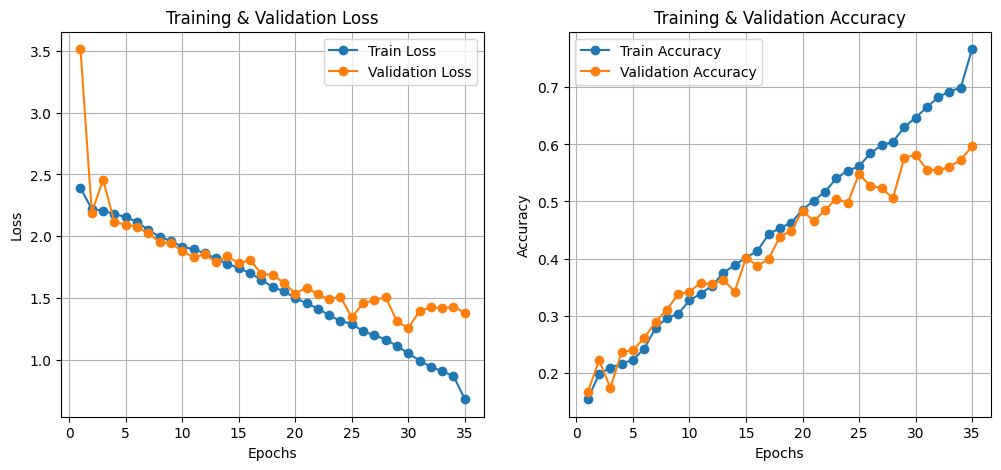

평균 손실: 1.2230
정확도: 59.90%


In [28]:
# 학습 과정 그래프 그리기
plot_training(history)

# 테스트 데이터 평가 실행
avg_test_loss, test_acc = test_model(model, test_loader, DEVICE)
print(f"평균 손실: {avg_test_loss:.4f}")
print(f"정확도: {test_acc * 100:.2f}%")

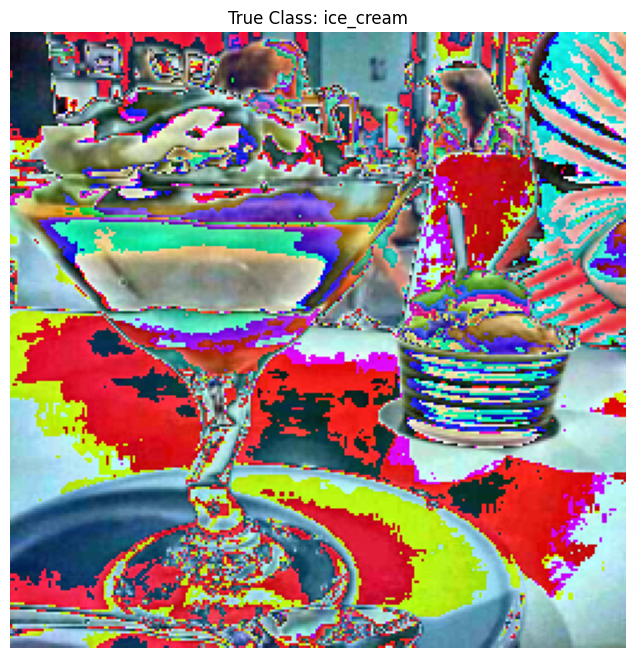

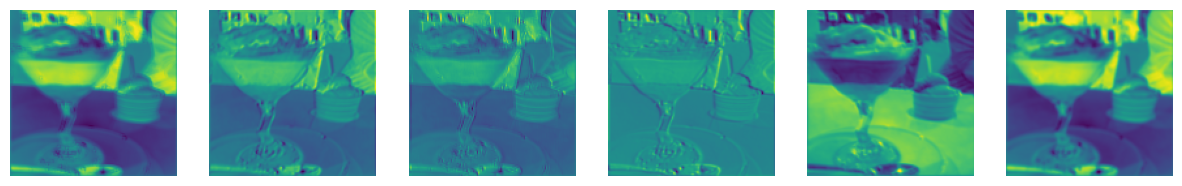

Top 5 Predictions:
ice_cream: 76.56%
sushi: 8.31%
carrot_cake: 7.51%
spring_rolls: 3.13%
oysters: 2.35%


In [32]:
# 샘플 이미지에 대한 예측 및 시각화 예시 코드
def visualize_sample_predictions():
    # 테스트 세트에서 몇 개의 샘플 가져오기
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # 샘플 이미지 선택
    sample_idx = 1
    sample_image = images[sample_idx]
    sample_label = labels[sample_idx]

    # 원본 이미지 표시
    plt.figure(figsize=(8, 8))
    plt.imshow(transforms.ToPILImage()(sample_image))
    plt.title(f"True Class: {class_names[sample_label]}")
    plt.axis('off')
    plt.show()

    # 특성 맵 시각화
    visualize_feature_maps(model, sample_image, DEVICE)

    # 상위 5개 예측 결과 출력
    predict_top5(model, sample_image, class_names, DEVICE)

# 샘플 이미지에 대한 시각화 실행
visualize_sample_predictions()